SINAV ÇALIŞMASIDIR

In [1]:
# ============================================================================
# KOD BLOĞU #1: Kütüphaneleri İçe Aktarma ve Veriyi Yükleme
# ============================================================================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Makine öğrenmesi için gerekli araçlar
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Kullanacağımız 3 farklı tahmin modeli
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# CSV dosyasından müşteri verilerini okuyoruz
df = pd.read_csv("data/Telco-Customer-Churn.csv")

# ============================================================================
# KOLON NUMARALAMA SİSTEMİ - Tüm projede kullanılacak
# ============================================================================
def create_column_mapping(dataframe):
    """
    DataFrame'deki tüm kolonları numaralandırır.
    Returns: {kolon_no: kolon_adı} sözlüğü
    """
    return {i+1: col for i, col in enumerate(dataframe.columns)}

def get_column_name(col_map, col_no):
    """Kolon numarasından kolon adını döndürür."""
    return col_map.get(col_no, None)

def get_column_number(col_map, col_name):
    """Kolon adından kolon numarasını döndürür."""
    for num, name in col_map.items():
        if name == col_name:
            return num
    return None

# İlk kolon haritasını oluştur
COLUMN_MAP = create_column_mapping(df)

# Kolon listesini yazdır
print("=" * 60)
print("KOLON NUMARALARI")
print("=" * 60)
for num, name in COLUMN_MAP.items():
    print(f"  [{num:2}] {name}")
print("=" * 60)

# İlk 5 satırı inceliyoruz
df.head()

KOLON NUMARALARI
  [ 1] customerID
  [ 2] gender
  [ 3] SeniorCitizen
  [ 4] Partner
  [ 5] Dependents
  [ 6] tenure
  [ 7] PhoneService
  [ 8] MultipleLines
  [ 9] InternetService
  [10] OnlineSecurity
  [11] OnlineBackup
  [12] DeviceProtection
  [13] TechSupport
  [14] StreamingTV
  [15] StreamingMovies
  [16] Contract
  [17] PaperlessBilling
  [18] PaymentMethod
  [19] MonthlyCharges
  [20] TotalCharges
  [21] Churn


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


VERİ SETİ ANALİZİ

Veri Boyutu: 7043 satır, 21 kolon

--------------------------------------------------------------------------------
KOLON TİP ANALİZİ
--------------------------------------------------------------------------------

 NO | KOLON ADI            | MEVCUT TİP | TAHMİN          | DURUM     
--------------------------------------------------------------------------------
[ 1] | customerID           | object     | id              | ID (Silinecek)
[ 2] | gender               | object     | categorical     | OK
[ 3] | SeniorCitizen        | int64      | numeric_int     | OK
[ 4] | Partner              | object     | categorical     | OK
[ 5] | Dependents           | object     | categorical     | OK
[ 6] | tenure               | int64      | numeric_int     | OK
[ 7] | PhoneService         | object     | categorical     | OK
[ 8] | MultipleLines        | object     | categorical     | OK
[ 9] | InternetService      | object     | categorical     | OK
[10] | OnlineSecurity    

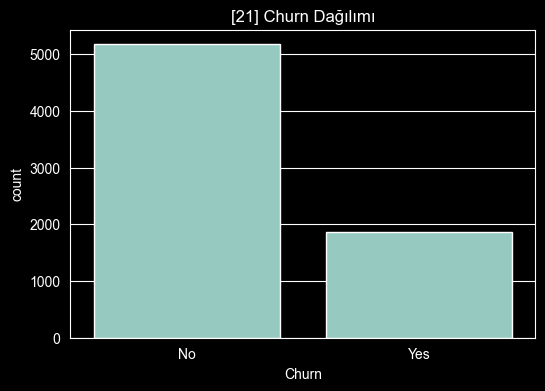

Churn
No     5174
Yes    1869
Name: count, dtype: int64



In [2]:
# ============================================================================
# KOD BLOĞU #2: Veriyi İnceleme ve Keşfetme (KOLON NUMARALARIYLA)
# ============================================================================

print("=" * 80)
print("VERİ SETİ ANALİZİ")
print("=" * 80)

# Veri boyutu bilgisi
print(f"\nVeri Boyutu: {df.shape[0]} satır, {df.shape[1]} kolon")

# Veri tiplerini inceleme
print("\n" + "-" * 80)
print("KOLON TİP ANALİZİ")
print("-" * 80)

def infer_real_dtype(series):
    """
    Bir kolonun gerçek veri tipini tahmin eder.
    İlk 5 ve son 5 satırdaki değerlere bakarak karar verir.
    """
    sample = pd.concat([series.head(5), series.tail(5)]).dropna()

    if len(sample) == 0:
        return 'unknown'

    # Sayıya çevirmeyi dene
    try:
        numeric_sample = pd.to_numeric(sample.astype(str).str.strip(), errors='coerce')
        success_rate = numeric_sample.notna().sum() / len(sample)

        if success_rate >= 0.8:
            if (numeric_sample.dropna() % 1 == 0).all():
                return 'numeric_int'
            else:
                return 'numeric_float'
    except:
        pass

    # Kategorik mi kontrol et
    unique_count = series.nunique()
    total_count = len(series)

    if unique_count <= max(10, int(total_count * 0.05)):
        return 'categorical'

    # ID kontrolü (tüm değerler benzersiz mi?)
    if unique_count == total_count:
        return 'id'

    return 'text'

# Analiz sonuçlarını sakla
analysis_results = {}
id_columns = []
suspicious_columns = []
target_column = None

print(f"\n{'NO':>3} | {'KOLON ADI':<20} | {'MEVCUT TİP':<10} | {'TAHMİN':<15} | {'DURUM':<10}")
print("-" * 80)

for col_no, col_name in COLUMN_MAP.items():
    current_dtype = str(df[col_name].dtype)
    inferred_type = infer_real_dtype(df[col_name])

    # Durumu belirle
    status = "OK"

    # ID sütunu mu?
    if inferred_type == 'id':
        status = "ID (Silinecek)"
        id_columns.append(col_name)

    # Tip uyumsuzluğu var mı?
    elif current_dtype == 'object' and inferred_type in ['numeric_int', 'numeric_float']:
        status = "UYUMSUZ"
        suspicious_columns.append(col_name)

    # Hedef sütun mu? (churn, target vb.)
    target_keywords = ['churn', 'target', 'label', 'class', 'outcome']
    if any(kw in col_name.lower() for kw in target_keywords):
        if df[col_name].nunique() == 2:
            status = "HEDEF"
            target_column = col_name

    # Sonuçları kaydet
    analysis_results[col_no] = {
        'name': col_name,
        'current_dtype': current_dtype,
        'inferred_type': inferred_type,
        'status': status
    }

    print(f"[{col_no:2}] | {col_name:<20} | {current_dtype:<10} | {inferred_type:<15} | {status}")

# Özet
print("\n" + "=" * 80)
print("ANALİZ ÖZETİ")
print("=" * 80)

if id_columns:
    id_nums = [get_column_number(COLUMN_MAP, c) for c in id_columns]
    print(f"ID Kolonları (silinecek): {id_nums} → {id_columns}")

if suspicious_columns:
    susp_nums = [get_column_number(COLUMN_MAP, c) for c in suspicious_columns]
    print(f"Uyumsuz Kolonlar (düzeltilecek): {susp_nums} → {suspicious_columns}")

if target_column:
    target_num = get_column_number(COLUMN_MAP, target_column)
    print(f"Hedef Kolon: [{target_num}] → {target_column}")

# Uyumsuz kolonların detaylı incelenmesi
if suspicious_columns:
    print("\n" + "-" * 80)
    print("UYUMSUZ KOLON DETAYLARI")
    print("-" * 80)

    for col_name in suspicious_columns:
        col_no = get_column_number(COLUMN_MAP, col_name)
        print(f"\n[{col_no}] {col_name}:")
        print(f"    İlk 5 değer: {df[col_name].head(5).tolist()}")

        # Boşluk karakteri kontrolü
        blank_count = (df[col_name].astype(str).str.strip() == '').sum()
        if blank_count > 0:
            print(f"    Boş değer sayısı: {blank_count}")

# Hedef değişken grafiği
if target_column:
    print("\n" + "-" * 80)
    print(f"HEDEF DEĞİŞKEN DAĞILIMI: [{get_column_number(COLUMN_MAP, target_column)}] {target_column}")
    print("-" * 80)

    plt.figure(figsize=(6,4))
    sns.countplot(x=target_column, data=df)
    plt.title(f"[{get_column_number(COLUMN_MAP, target_column)}] {target_column} Dağılımı")
    plt.show()

    print(df[target_column].value_counts())

print("\n" + "=" * 80)


In [3]:
# ============================================================================
# KOD BLOĞU #3: Veri Temizleme ve Hazırlama (KOLON NUMARALARIYLA)
# ============================================================================

print("=" * 80)
print("VERİ TEMİZLEME")
print("=" * 80)

# 1. ID KOLONLARINI SİL
print("\n[1] ID Kolonlarının Silinmesi:")
print("-" * 40)

if id_columns:
    for col_name in id_columns:
        col_no = get_column_number(COLUMN_MAP, col_name)
        print(f"    [{col_no}] {col_name} siliniyor...")
    df = df.drop(id_columns, axis=1)
    print(f"    Silinen kolon sayısı: {len(id_columns)}")
else:
    print("    ID kolonu bulunamadı")

# Kolon haritasını güncelle
COLUMN_MAP = create_column_mapping(df)

# 2. UYUMSUZ KOLONLARI DÜZELT
print("\n[2] Uyumsuz Kolonların Düzeltilmesi:")
print("-" * 40)

if suspicious_columns:
    for col_name in suspicious_columns:
        if col_name in df.columns:
            col_no = get_column_number(COLUMN_MAP, col_name)

            # Sayıya çevir
            df[col_name] = pd.to_numeric(df[col_name], errors='coerce')

            # Eksik değerleri medyan ile doldur
            missing_count = df[col_name].isna().sum()
            if missing_count > 0:
                median_val = df[col_name].median()
                df[col_name] = df[col_name].fillna(median_val)
                print(f"    [{col_no}] {col_name}: {missing_count} eksik değer medyan ({median_val:.2f}) ile dolduruldu")
            else:
                print(f"    [{col_no}] {col_name}: Sayıya çevrildi, eksik değer yok")
else:
    print("    Düzeltilecek kolon bulunamadı")

# 3. HEDEF DEĞİŞKENİ DÖNÜŞTÜR
print("\n[3] Hedef Değişken Dönüşümü:")
print("-" * 40)

if target_column and target_column in df.columns:
    target_no = get_column_number(COLUMN_MAP, target_column)
    print(f"    Hedef kolon: [{target_no}] {target_column}")
    print(f"    Mevcut değerler: {df[target_column].unique().tolist()}")

    # Eğer object tipindeyse sayıya çevir
    if df[target_column].dtype == 'object':
        unique_vals = df[target_column].unique()
        positive_keywords = ['yes', 'true', '1', 'positive', 'churn']

        target_map = {}
        for val in unique_vals:
            if str(val).lower() in positive_keywords:
                target_map[val] = 1
            else:
                target_map[val] = 0

        df[target_column] = df[target_column].map(target_map)
        print(f"    Dönüşüm: {target_map}")
    else:
        print(f"    Zaten sayısal tipte: {df[target_column].dtype}")
else:
    # Hedef kolon bulunamadıysa Churn'ü ara
    if 'Churn' in df.columns:
        target_column = 'Churn'
        target_no = get_column_number(COLUMN_MAP, target_column)
        print(f"    Varsayılan hedef: [{target_no}] {target_column}")

        if df[target_column].dtype == 'object':
            target_map = {'Yes': 1, 'No': 0}
            df[target_column] = df[target_column].map(target_map)
            print(f"    Dönüşüm: {target_map}")

# 4. KATEGORİK VERİLERİ DÖNÜŞTÜR
print("\n[4] Kategorik Verilerin Dönüştürülmesi (One-Hot Encoding):")
print("-" * 40)

# Object tipindeki kolonları bul (hedef hariç)
categorical_cols = df.select_dtypes(include='object').columns.tolist()

if target_column in categorical_cols:
    categorical_cols.remove(target_column)

if categorical_cols:
    cat_nums = [get_column_number(COLUMN_MAP, c) for c in categorical_cols]
    print(f"    Kategorik kolonlar: {cat_nums}")
    print(f"    Kolon adları: {categorical_cols}")

    # One-Hot Encoding uygula
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    print(f"    One-Hot Encoding uygulandı")
    print(f"    Yeni kolon sayısı: {len(df.columns)}")
else:
    print("    Kategorik kolon bulunamadı")

# Kolon haritasını güncelle
COLUMN_MAP = create_column_mapping(df)

# Son durum
print("\n" + "=" * 80)
print("TEMİZLEME SONRASI VERİ")
print("=" * 80)
print(f"Boyut: {df.shape[0]} satır, {df.shape[1]} kolon")
print(f"\nİlk 5 kolon:")
for i, (num, name) in enumerate(COLUMN_MAP.items()):
    if i >= 5:
        print(f"    ... ve {len(COLUMN_MAP) - 5} kolon daha")
        break
    print(f"    [{num}] {name}")

df.head()

VERİ TEMİZLEME

[1] ID Kolonlarının Silinmesi:
----------------------------------------
    [1] customerID siliniyor...
    Silinen kolon sayısı: 1

[2] Uyumsuz Kolonların Düzeltilmesi:
----------------------------------------
    [19] TotalCharges: 11 eksik değer medyan (1397.47) ile dolduruldu

[3] Hedef Değişken Dönüşümü:
----------------------------------------
    Hedef kolon: [20] Churn
    Mevcut değerler: ['No', 'Yes']
    Dönüşüm: {'No': 0, 'Yes': 1}

[4] Kategorik Verilerin Dönüştürülmesi (One-Hot Encoding):
----------------------------------------
    Kategorik kolonlar: [1, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
    Kolon adları: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
    One-Hot Encoding uygulandı
    Yeni kolon sayısı: 31

TEMİZLEME SONRASI VERİ
Boyut: 7043 satır,

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,False,True,False,False,True,...,False,False,False,False,False,False,True,False,True,False
1,0,34,56.95,1889.50,0,True,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
2,0,2,53.85,108.15,1,True,False,False,True,False,...,False,False,False,False,False,False,True,False,False,True
3,0,45,42.30,1840.75,0,True,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
4,0,2,70.70,151.65,1,False,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False


In [4]:
# ============================================================================
# KOD BLOĞU #4: Veriyi Eğitim ve Test Olarak Ayırma (KOLON NUMARALARIYLA)
# ============================================================================

print("=" * 80)
print("VERİ BÖLME VE ÖLÇEKLENDİRME")
print("=" * 80)

# 1. HEDEF KOLONU BUL
print("\n[1] Hedef Kolon:")
print("-" * 40)

# target_column değişkeni Kod Bloğu #2'den geliyor
if target_column and target_column in df.columns:
    target_no = get_column_number(COLUMN_MAP, target_column)
    print(f"    Hedef: [{target_no}] {target_column}")
else:
    # Churn'ü ara
    target_column = 'Churn'
    target_no = get_column_number(COLUMN_MAP, target_column)
    print(f"    Varsayılan hedef: [{target_no}] {target_column}")

# 2. X VE Y AYIR
print("\n[2] Özellik (X) ve Hedef (y) Ayrımı:")
print("-" * 40)

y = df[target_column]
X = df.drop(target_column, axis=1)

print(f"    Hedef (y): [{target_no}] {target_column}")
print(f"    Özellik (X): {X.shape[1]} kolon")
print(f"    Hedef dağılımı: 0 → {(y == 0).sum()}, 1 → {(y == 1).sum()}")

# 3. DENGESİZLİK KONTROLÜ
print("\n[3] Dengesizlik Kontrolü:")
print("-" * 40)

class_ratio = y.value_counts(normalize=True)
minority_ratio = class_ratio.min()

if minority_ratio < 0.3:
    print(f"    Dengesiz veri tespit edildi!")
    print(f"    Azınlık sınıf oranı: {minority_ratio:.1%}")
    print(f"    stratify=y kullanılacak")
else:
    print(f"    Veri dengeli (azınlık oranı: {minority_ratio:.1%})")

# 4. EĞİTİM/TEST BÖLME
print("\n[4] Eğitim/Test Bölme:")
print("-" * 40)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"    Eğitim seti: {len(X_train)} satır (%80)")
print(f"    Test seti: {len(X_test)} satır (%20)")

# 5. ÖLÇEKLENDİRME
print("\n[5] Özellik Ölçeklendirme (StandardScaler):")
print("-" * 40)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"    Tüm özellikler ölçeklendirildi")
print(f"    Ortalama: 0, Standart Sapma: 1")

print("\n" + "=" * 80)

VERİ BÖLME VE ÖLÇEKLENDİRME

[1] Hedef Kolon:
----------------------------------------
    Hedef: [5] Churn

[2] Özellik (X) ve Hedef (y) Ayrımı:
----------------------------------------
    Hedef (y): [5] Churn
    Özellik (X): 30 kolon
    Hedef dağılımı: 0 → 5174, 1 → 1869

[3] Dengesizlik Kontrolü:
----------------------------------------
    Dengesiz veri tespit edildi!
    Azınlık sınıf oranı: 26.5%
    stratify=y kullanılacak

[4] Eğitim/Test Bölme:
----------------------------------------
    Eğitim seti: 5634 satır (%80)
    Test seti: 1409 satır (%20)

[5] Özellik Ölçeklendirme (StandardScaler):
----------------------------------------
    Tüm özellikler ölçeklendirildi
    Ortalama: 0, Standart Sapma: 1



MODEL 1: LOGISTIC REGRESSION

Accuracy: 0.8070 (80.70%)

Detaylı Rapor:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.66      0.57      0.61       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409



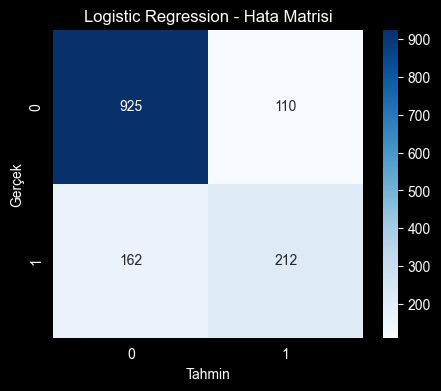

In [5]:
# ============================================================================
# KOD BLOĞU #5: Model 1 - Logistic Regression
# ============================================================================
# En basit sınıflandırma modeli
# Her özelliğe ağırlık verir, ağırlıklı toplam 0.5'ten büyükse → Churn=1

print("=" * 80)
print("MODEL 1: LOGISTIC REGRESSION")
print("=" * 80)

# Modeli oluştur ve eğit
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

# Tahmin yap
y_pred_log = log_model.predict(X_test)

# Sonuçları kaydet
log_accuracy = accuracy_score(y_test, y_pred_log)

print(f"\nAccuracy: {log_accuracy:.4f} ({log_accuracy*100:.2f}%)")
print("\nDetaylı Rapor:")
print(classification_report(y_test, y_pred_log))

# Hata Matrisi
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True, fmt='d', cmap='Blues')
plt.title("Logistic Regression - Hata Matrisi")
plt.ylabel('Gerçek')
plt.xlabel('Tahmin')
plt.show()

MODEL 2: RANDOM FOREST

Accuracy: 0.7857 (78.57%)

Detaylı Rapor:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.62      0.49      0.55       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.70      1409
weighted avg       0.77      0.79      0.78      1409



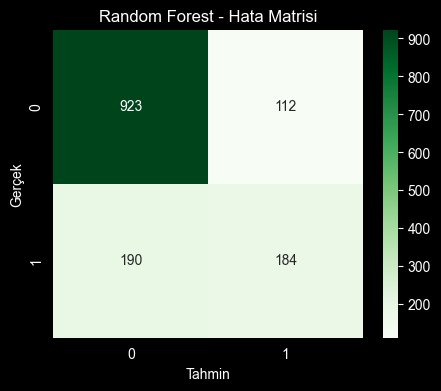

In [6]:
# ============================================================================
# KOD BLOĞU #6: Model 2 - Random Forest
# ============================================================================
# Birden fazla karar ağacı oluşturur (100 ağaç)
# Tüm ağaçlar oy kullanır, çoğunluk kazanır

print("=" * 80)
print("MODEL 2: RANDOM FOREST")
print("=" * 80)

# Modeli oluştur ve eğit
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Tahmin yap
y_pred_rf = rf_model.predict(X_test)

# Sonuçları kaydet
rf_accuracy = accuracy_score(y_test, y_pred_rf)

print(f"\nAccuracy: {rf_accuracy:.4f} ({rf_accuracy*100:.2f}%)")
print("\nDetaylı Rapor:")
print(classification_report(y_test, y_pred_rf))

# Hata Matrisi
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Greens')
plt.title("Random Forest - Hata Matrisi")
plt.ylabel('Gerçek')
plt.xlabel('Tahmin')
plt.show()

MODEL 3: XGBOOST

Accuracy: 0.7850 (78.50%)

Detaylı Rapor:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1035
           1       0.61      0.53      0.57       374

    accuracy                           0.78      1409
   macro avg       0.72      0.71      0.71      1409
weighted avg       0.78      0.78      0.78      1409



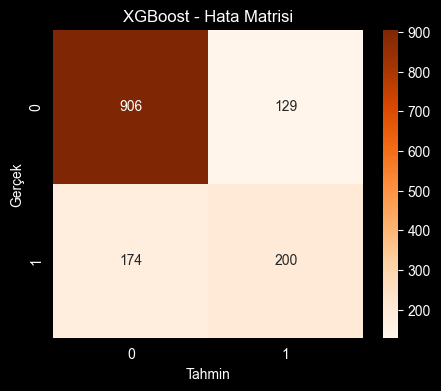

In [7]:
# ============================================================================
# KOD BLOĞU #7: Model 3 - XGBoost
# ============================================================================
# Gradient boosting tekniği kullanır
# Her yeni ağaç, önceki ağacın hatalarını düzeltmeye çalışır

print("=" * 80)
print("MODEL 3: XGBOOST")
print("=" * 80)

# Modeli oluştur ve eğit
# logloss: Modelin tahminlerindeki güveni de ölçer
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Tahmin yap
y_pred_xgb = xgb_model.predict(X_test)

# Sonuçları kaydet
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)

print(f"\nAccuracy: {xgb_accuracy:.4f} ({xgb_accuracy*100:.2f}%)")
print("\nDetaylı Rapor:")
print(classification_report(y_test, y_pred_xgb))

# Hata Matrisi
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Oranges')
plt.title("XGBoost - Hata Matrisi")
plt.ylabel('Gerçek')
plt.xlabel('Tahmin')
plt.show()

MODEL KARŞILAŞTIRMA

📊 MODEL PERFORMANS TABLOSU:
--------------------------------------------------
🥇 Logistic Regression       | Accuracy: 0.8070
🥈 Random Forest             | Accuracy: 0.7857
🥉 XGBoost                   | Accuracy: 0.7850

🏆 EN İYİ MODEL: Logistic Regression
   Accuracy: 0.8070 (80.70%)


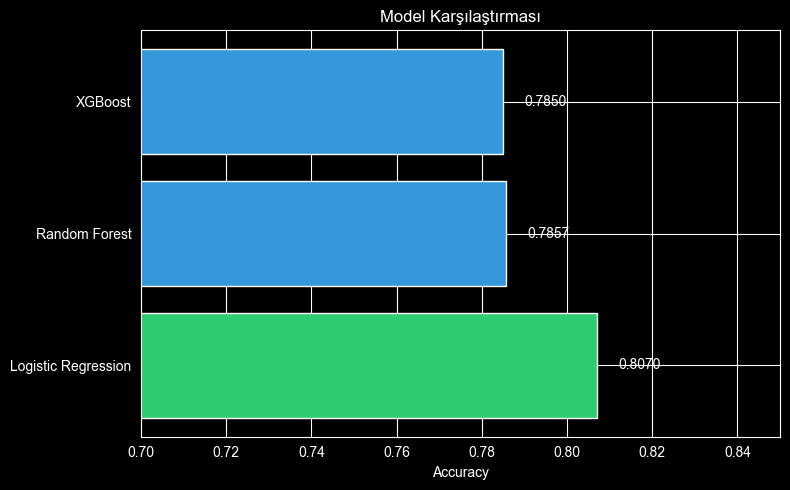


📌 SONUÇ:
   Bu veri seti için Logistic Regression modeli en iyi performansı gösterdi.
   Model, test verisinde 80.70% doğruluk oranına ulaştı.


In [8]:
# ============================================================================
# KOD BLOĞU #8: Model Karşılaştırma ve Sonuç
# ============================================================================

print("=" * 80)
print("MODEL KARŞILAŞTIRMA")
print("=" * 80)

# Sonuç tablosu
results = {
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [log_accuracy, rf_accuracy, xgb_accuracy]
}

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Accuracy', ascending=False).reset_index(drop=True)

print("\n📊 MODEL PERFORMANS TABLOSU:")
print("-" * 50)
for idx, row in results_df.iterrows():
    rank = "🥇" if idx == 0 else "🥈" if idx == 1 else "🥉"
    print(f"{rank} {row['Model']:25} | Accuracy: {row['Accuracy']:.4f}")

# En iyi model
best_model_name = results_df.iloc[0]['Model']
best_accuracy = results_df.iloc[0]['Accuracy']

print("\n" + "=" * 80)
print(f"🏆 EN İYİ MODEL: {best_model_name}")
print(f"   Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
print("=" * 80)

# Görsel karşılaştırma
plt.figure(figsize=(8, 5))
colors = ['#2ecc71' if m == best_model_name else '#3498db' for m in results_df['Model']]
bars = plt.barh(results_df['Model'], results_df['Accuracy'], color=colors)
plt.xlabel('Accuracy')
plt.title('Model Karşılaştırması')
plt.xlim(0.7, 0.85)

for bar, acc in zip(bars, results_df['Accuracy']):
    plt.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
             f'{acc:.4f}', va='center')

plt.tight_layout()
plt.show()

print("\n📌 SONUÇ:")
print(f"   Bu veri seti için {best_model_name} modeli en iyi performansı gösterdi.")
print(f"   Model, test verisinde {best_accuracy*100:.2f}% doğruluk oranına ulaştı.")
